## Momentum Strategy 

### Introduction
This tutorial will introduce you to basic ideas behind momentum trading strategies employed by traders and hedge fund managers. As opposed to traditional value investing methods that primarily analyzed company's operational performances, momentum strategy strictly relies on technical analysis of stock price movements to predict the direction of equity prices. Specifically, this strategy is based on an assumption that continuing trend, or a momentum, over a fixed range of period will continue in its direction. Because this method involves heavy technical analysis on stock price data, it inevitably utilizes various data analysis techniques and sometimes even cutting-edge machine learning methods like deep learning. In this tutorial, we will implement a simple momentum strategy by making long/short decisions based on comparing moving averages. 


### Contents
We will primarily make use of two pandas libraries, pandas ta and pandas datareader, to collect adjusted stock price data and conduct technical analysis. 

For the purpose of this tutorial, we will use Apple(AAPL) as our selected stock and our only traded stock. If you wish to apply this simple momentum strategy against other publicly traded companies, you can search their tickers (abbreviated stock symbols for publicly traded companies) on google to get appropriate data from pandas datareader.

This tutorial will cover the following topics: 

1. [Library installation](#Library-Installation)
2. [Collect stock data](#Data-Collection-and-Visualization)
3. [Raw prices to Daily returns](#Returns-vs-Raw-Prices)
4. [Momentum Strategies](#Devising-Strategies)
5. [BackTesting and Annual Returns](#Backtesting-and-Annual-Return)
6. [Forward Testing](#"Forward-Testing"-our-Strategy)





### Library Installation

If you are not already familiar with pandas library and its data structures, please review [pandas user guide](https://pandas.pydata.org/docs/user_guide/index.html) to familiarize yourself before proceeding any further. You would at least want to get comfortable with Dataframe and Series indexing for this tutorial. Also, we will assume that you feel comfortable using numpy and python datetime libraries. 

In building simple momentum strategy, we need the help of two libraries listed below:

1. [Pandas datareader](https://pypi.org/project/pandas-datareader/)
<br>Pandas datareader is a very useful library in collecting financial data such as currency rates, stock prices, economic dataset, financial indicator / ratio, from multiple sources. You can install this library using the `pip` command on your selected anaconda environment as below:

    `$ pip install pandas-datareader`  
<br>
2. [Pandas ta](https://pypi.org/project/pandas-ta/)
<br>Pandas ta, or pandas technical analysis, provides numerous methods for generating financial indicators and devising investment strategies. Similarly, you can install this library using the `pip` command on your selected anaconda environment as below:

    `$ pip install pandas-ta`  

*Although the two libraries have 'pandas' in their names, these are actually separate libraries that utilize pandas Dataframe structures and data types when collecting and analyzing data. Along with pandas library (which is pre-installed in base anaconda package), It is important that these libraries are installed as well. 

In [21]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from datetime import date, datetime, timedelta
import pandas_ta as ta

### Data Collection and Visualization

Now that we have all the necessary ingredients in building simple momentum strategy, we will now begin implementing by collecting data using datareader. From the pandas datareader, we will import `DataReader()` method that takes in ticker symbol `AAPL` , name of data source `yahoo` , and a range of period to extract data from to return stock prices of a publicly traded company in a fixed range of period. Because Apple went public on December 12, 1980, we will collect apple's stock price data beginning from January 2, 1981 to December 31, 2020 (These data will later be used for backtesting our hypothetical strategies and any stock prices afterwards will be used as "fowardtesting" data)

In [22]:
ticker = 'AAPL'
source = 'yahoo'
start_date = date(1981,1,2)
end_date = date(2020,12,31)
apple_data = DataReader(ticker,source,start_date,end_date)
apple_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1981-01-02,0.155134,0.154018,0.154018,0.154018,21660800.0,0.121107
1981-01-05,0.151228,0.150670,0.151228,0.150670,35728000.0,0.118474
1981-01-06,0.144531,0.143973,0.144531,0.143973,45158400.0,0.113208
1981-01-07,0.138393,0.137835,0.138393,0.137835,55686400.0,0.108382
1981-01-08,0.135603,0.135045,0.135603,0.135045,39827200.0,0.106188


We can see that we successfully retrieved data in a `DataFrame` type from yahoo finance! Our collected data shows High, Low, Open, Close, and Adjusted closing prices(in USD per stock) along with volume of traded stocks on a daily basis for normal business days(days when stock market is open). Since we only need Adjusted Closing price, we will subset the data by only selecting 'Adj Close' column.

In [23]:
apple_data = apple_data['Adj Close']
apple_data.head()

Date
1981-01-02    0.121107
1981-01-05    0.118474
1981-01-06    0.113208
1981-01-07    0.108382
1981-01-08    0.106188
Name: Adj Close, dtype: float64

When we subset our data for a single column 'Adj Close', our dataset is now in a `Series` type. Because it is more convenient to use `DataFrame` (for arithmetic and visualization purposes later on), we will convert our data into `DataFrame` type. This can be simply done by wrapping our data with `pd.DataFrame()` method. 

In [24]:
apple_data = pd.DataFrame(apple_data)
apple_data.head()

,Adj Close
Date,
1981-01-02,0.121107
1981-01-05,0.118474
1981-01-06,0.113208
1981-01-07,0.108382
1981-01-08,0.106188


To get a better sense of how adjusted closing prices are distributed, we can use `.plot()` method that readily interprets `DataFrame` type. The first graph shows how adjusted closing price change with respect to time while second histogram shows a univariate distribution of adjusted closing price separated in 100 bins.

<AxesSubplot:ylabel='Frequency'>

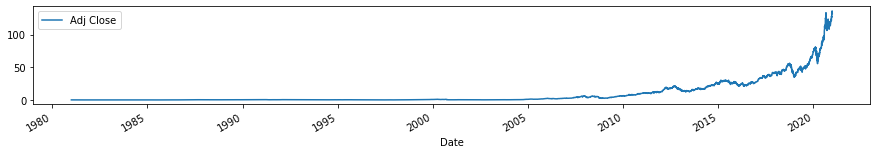

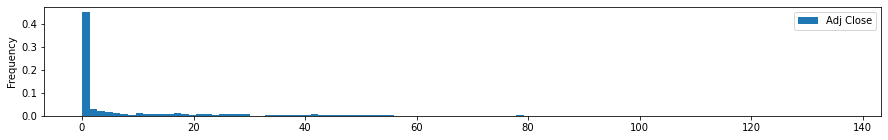

In [25]:
apple_data.plot(figsize = (15,2))
nbins = 100
apple_data.plot(kind = 'hist', density=True, bins = nbins, figsize = (15,2))

### Returns vs Raw Prices

Before using our data for momentum strategy, we have to make an important change to the data: <b>changing raw adjusted closing price into returns</b>. Why is this important? According to the random walk theory, the future stock prices are independent of past stock prices, which implies that estimated predictions based on historical stock prices are meaningless. Thus, we need to make an adjustment to such non-stationary process so that our estimates may be useful. 

One way to approach this problem is to convert this data into stationary series, by calculating daily returns from percentage difference in adjusted closing prices. In fact, this can be very easily calculated using the `.pct_change()` method!

Because our first day (1981-01-02) does not have a previous date and price, the return for the first day will be returned as `Nan` type. For simplicity, we will convert `Nan` type to return of 0 by using `.fillna(0)`.

Interestingly, we can see how the univariate distribution of our data has changed from a right skewed to approximately normal distribution, becoming much easier for additional statistical analysis if needed. 

<AxesSubplot:ylabel='Frequency'>

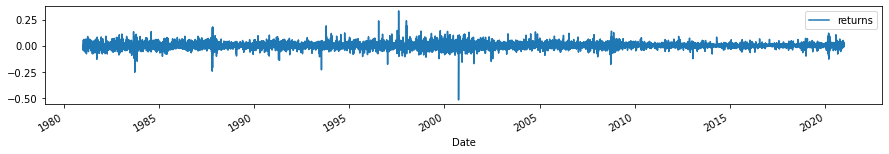

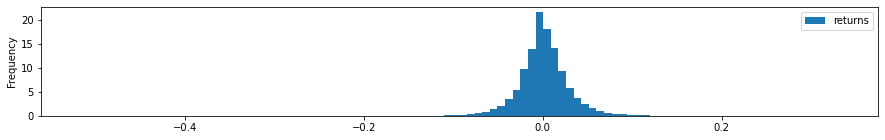

In [26]:
returns = apple_data.pct_change()
returns = returns.fillna(0) 
col_name = {'Adj Close':'returns'}
returns = returns.rename(columns = col_name)
returns.plot(figsize = (15,2))
returns.plot(kind = 'hist', density=True, bins = 100 ,figsize = (15,2))

Also, we can see for what number of day we had positive returns (profit), negative returns (loss), and 0 return. From period 1981-1-2 to 2020-12-31, Apple had positive returns for 5000 days, negative returns for 4718 days, and 0 returns for 368 days. Because there is no significant difference between number of days of positive and negative returns, we have to come up with a strategy to make smart investment decisions! 

In [27]:
col_name = 'returns'
pos = sum((returns > 0).astype(int)[col_name])
neg = sum((returns < 0).astype(int)[col_name])
zero = sum((returns == 0).astype(int)[col_name])
(pos,neg,zero)

(5000, 4718, 368)

### Devising Strategies

Finally! Now that we have pre-processed data and necessary tools ready, let's devise several hypothetical momentum strategies. We will use pandas-ta's `.sma()` method to compute simple moving averages(SMA) of daily returns on a given number of days. Simply put, SMA_3 is equivalent to average returns across 3 days. To test against various market volatility, we will test 3 hypothetical momentum strategies that make long/short decisions on different time-ranged moving averages. 

1. <b>Strategy 1 : Short-Term Momentum Strategy</b>
    - Buy if SMA_3 > SMA_14
    - Sell if SMA_3 < SMA_14
<br>
<br>
2. <b>Strategy 2 : Long-Term Momentum Strategy</b>
    - Buy if SMA_50 > SMA_200
    - Sell if SMA_50 < SMA_200
<br>
<br>
3. <b>Strategy 3 : Daily Momentum Strategy</b>
    - Buy if daily returns > SMA_50
    - Sell if daily returns < SMA_50
<br>

First, we will create DataFrame that takes positions buy = 1, sell = -1, nothing = 0 based on each strategies' comparisons. Because moving averages of length <i>d</i> can only be computed after at least d days have passed, we will substitute position 0 for such days. 

In [28]:
def processed_sma(d,data):
    sma = pd.DataFrame(ta.sma(data['returns'], length=d))
    sma = sma.fillna(0)
    return sma

def Positions(ma1,ma2):
    col1 = ma1.columns[0]
    col2 = ma2.columns[0]
    buyPositions = ma1[col1] > ma2[col2]
    buyPositions = buyPositions.astype(int) #Convert boolean to integer types
    sellPositions = ma1[col1] < ma2[col2]
    sellPositions = sellPositions.astype(int) * -1
    positions = pd.DataFrame(buyPositions + sellPositions)
    col_name = {0:'decision'}
    positions = positions.rename(columns = col_name)
    return positions

We can observe that each strategy takes values of -1,0, or 1 differently for each days as different moving averages / returns were compared. Notice that strategy 2 does not take any action for the first 20 days because the compared moving averages of 50 and 200 are both 0. This could become problematic as this particular strategy is penalized from making profits compared to other strategies in that given range of time. Thus, to make better comparisons between each hypothesized strategies, we will ignore the first 400 days (only after 400th day would the longest sma of 200 days would not use default value of 0). 

<AxesSubplot:xlabel='Date'>

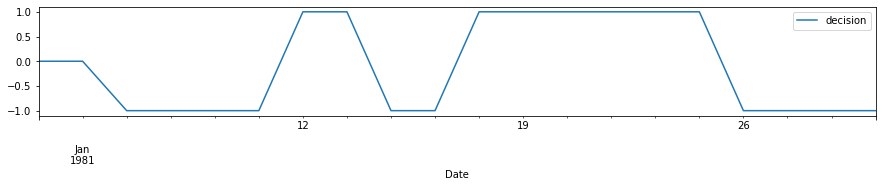

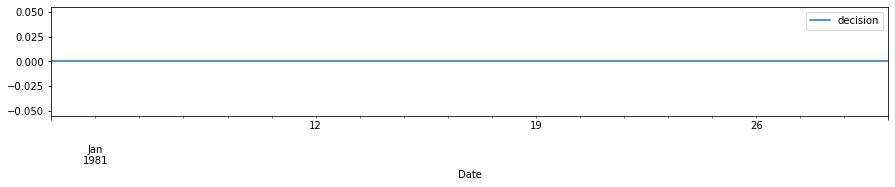

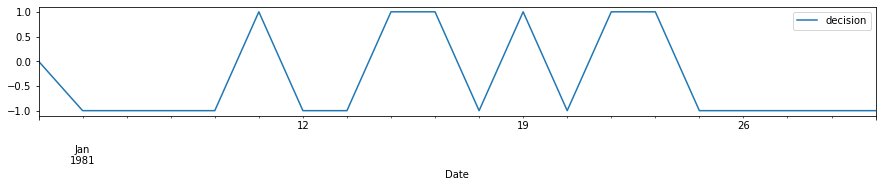

In [29]:
sma3 = processed_sma(3,returns)
sma14 = processed_sma(14,returns)
sma50 = processed_sma(50,returns)
sma200 = processed_sma(200,returns)

strategy1 = Positions(sma3,sma14) # moving average 3 vs moving average 14
strategy2 = Positions(sma50,sma200) # moving average 50 vs moving average 200
strategy3 = Positions(returns,sma50) # daily returns vs moving average 50

strategy1.head(20).plot(figsize = (15,2))
strategy2.head(20).plot(figsize = (15,2))
strategy3.head(20).plot(figsize = (15,2))

After adjusting for such penalizing effect, we can see that strategy 2 now does not take unnecessary 0 positions, but meaningful long/short decisions, and that all strategies are making varying decisions.

<AxesSubplot:xlabel='Date'>

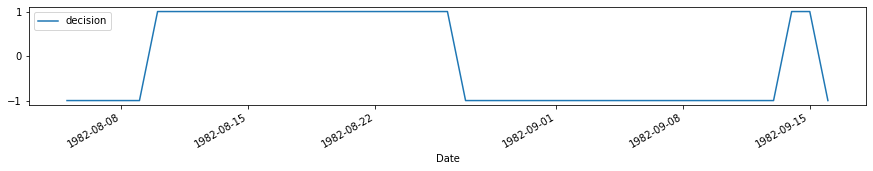

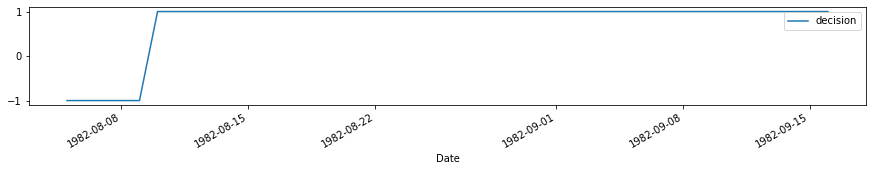

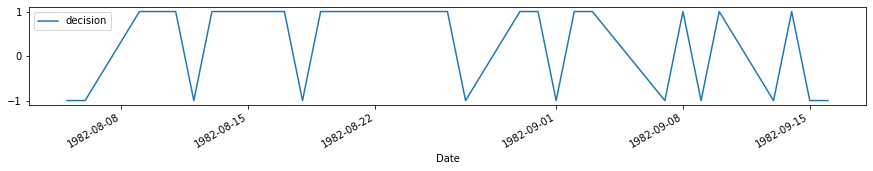

In [30]:
strategy1 = strategy1[401:]
strategy2 = strategy2[401:]
strategy3 = strategy3[401:]
strategy1.head(30).plot(figsize = (15,2))
strategy2.head(30).plot(figsize = (15,2))
strategy3.head(30).plot(figsize = (15,2))

Comparing daily positions that strategies take on 9685 days, we see that strategy 1 and 2 take same positions for 4777 days, strategy 1 and 3 for 6289 days, and strategy 2 and 3 for 4743 days. Although it appears that a great portion of daily positions overlap amongst strategies, we will examine how much they actually differ when we compute and compare their annual returns.

In [31]:
col_name = 'decision'
strat12_same = sum((strategy1 == strategy2).astype(int)[col_name])
strat13_same = sum((strategy1 == strategy3).astype(int)[col_name])
strat23_same = sum((strategy2 == strategy3).astype(int)[col_name])
(strat12_same,strat13_same,strat23_same)

(4777, 6289, 4743)

### Backtesting and Annual Return

Now that we know when to buy and sell, let's actually make some purchases!  It is crucial that we test our strategy before applying it to real stock market so that we can measure strategies' performances. The process of verifying hypothesized trading strategies against past data is called `backtesting`. As mentioned previously, the data from 1981-1-2 to 2020-12-31, the data we have been analyzing, will be used for backtesting. To do so, we will introduce `lookahead returns`, or returns shifted to a previous day, to compute how much returns we will earn or lose on arbitrary day 2 if we take certain position on arbitrary day 1. 

In [32]:
returns['lookahead returns'] = returns['returns'].shift(-1)
returns = returns[401:] # to ignore first 400 days
returns.head()

,returns,lookahead returns
Date,,
1982-08-05,-0.038832,-0.010101
1982-08-06,-0.010101,0.010204
1982-08-09,0.010204,0.060601
1982-08-10,0.060601,0.009523
1982-08-11,0.009523,-0.009433


We can see how a return on some arbitrary day 2 has been shifted to its previous day. For example, suppose we buy on 1982-08-05. Because our next day's return, or lookahead return, is -0.010101, we know that we will be losing money on 1982-08-06. We will now multiply lookahead returns column by each of our strategies to see how well they performed in terms of average annual returns. 

In [33]:
def annualReturns(returns,strategy):
    annual = 365
    lookahead = returns['lookahead returns']
    positions = strategy['decision']
    daily_returns = positions * lookahead
    # lookahead returns have Nan on last date 
    # because there is no next day of last day in our data
    daily_returns = daily_returns.dropna() 
    avg_daily_returns = daily_returns.mean(axis = 0)
    annual_return = avg_daily_returns * annual
    return annual_return

In [34]:
return1 = annualReturns(returns,strategy1)
return2 = annualReturns(returns,strategy2)
return3 = annualReturns(returns,strategy3)
(return1,return2,return3)

(-0.20049094094055864, 0.22496809204654228, 0.11224014861891085)

Although the long/short decisions for each strategy seems to overlap greatly, we can see that their results differ very much in terms of average annual returns. From our 3 strategies, we can see that strategies 2 and 3 had positive returns of approximately 0.22497 and 0.11224, respectively, while strategy 1 had negative return of 0.20049. Thus, our optimal strategy based on backtesting result is strategy 2. 

Then, assuming that we initially made one dollar investment, we can use daily returns of strategy 2 to compute how much we would have made by the end of backtesting period by taking cumulative product of subsequent period's return. This can be done by simply calling `cumprod()` over `1 + daily returns`.

We can see that our initial investment of 1 dollar grew up to 8.05 dollars, or equivalently 805% increase, by 2020-12-30 using strategy 2. 

In [35]:
strategy2_daily_returns = (returns['lookahead returns'] * strategy2['decision']).dropna()
investment = 1
cum_returns = (1 + strategy2_daily_returns).cumprod()
col_name = {0 : 'Investment Result'}
investment_outcome = (investment * cum_returns).to_frame().rename(columns = col_name)
investment_outcome.tail()

,Investment Result
Date,
2020-12-23,8.109693
2020-12-24,7.819644
2020-12-28,7.923761
2020-12-29,7.991325
2020-12-30,8.052879


We can visually represent the change in my investment results as below. Based on the plot, our investment actually even peaked at around $35, yielding investment return of 3500%! 

<AxesSubplot:xlabel='Date'>

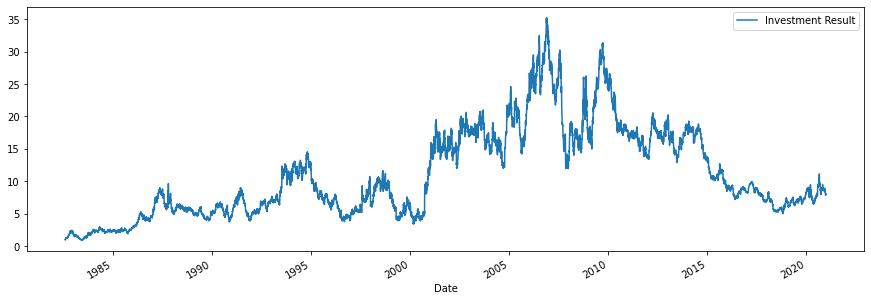

In [36]:
investment_outcome.plot(figsize = (15,5))

### "Forward Testing" our Strategy

Assume that it is 2021-01-01 today, and we are ready to use strategy 2 against the market! Let's see if we can actually make some dough when the market opens on the first weekday of 2021, 2021-01-04. Assuming that we made trades on a daily basis by taking positions given by strategy 2, it can be implemented similarly as we have done throughout this tutorial. 

Because we feel comfortable that our strategy is profitable, we will invest 10,000 dollars! Let's see what happens. 


In [37]:
# Collect stock data of Apple from Yahoo Finance. 
start_date = date(2019,6,2) #to calculate sma of 200, we need data 400 days before 2021-01-04, which is 2019-06-02
end_date = date(2021,3,31)
ticker = 'AAPL'
source = 'yahoo'
cur_data = DataReader(ticker,source,start_date,end_date)

# Process data to our use 
adj_data = cur_data['Adj Close']
pd_adj_data = adj_data.to_frame()
returns = pd_adj_data['Adj Close'].pct_change()
adj_returns = returns.fillna(0).to_frame()
col_name = {'Adj Close':'returns'}
processed_returns = adj_returns.rename(columns = col_name)

# Calculate moving averages and take positions on each day
sma50 = processed_sma(50,processed_returns)
sma200 = processed_sma(200,processed_returns)
strategy2 = Positions(sma50,sma200)

# Ignore first 400 days to start out trade on 2021-01-04
processed_returns = processed_returns[401:]

# Compute daily returns using strategy 2 
processed_returns['lookahead returns'] = processed_returns['returns'].shift(-1)
strategy2_daily_returns = (processed_returns['lookahead returns'] * strategy2['decision']).dropna()

# Invest! 
investment = 10000
cum_returns = (1 + strategy2_daily_returns).cumprod()
col_name = {0 : 'Investment Result'}
investment_outcome = (investment * cum_returns).to_frame().rename(columns = col_name)
investment_outcome.tail()

,Investment Result
Date,
2021-03-24,10507.381208
2021-03-25,10453.358441
2021-03-26,10437.834906
2021-03-29,10565.953794
2021-03-30,10367.676932


<AxesSubplot:xlabel='Date'>

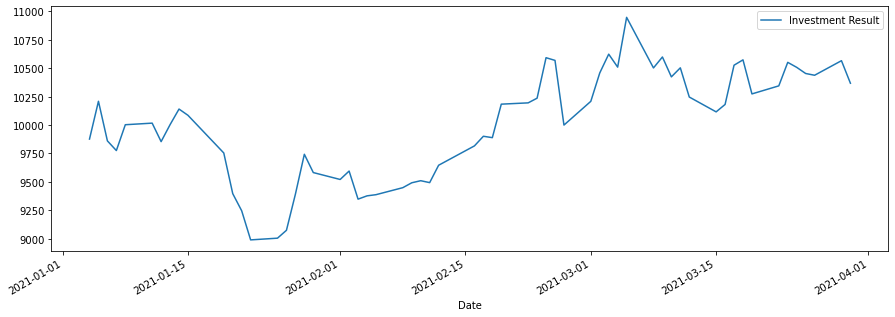

In [38]:
investment_outcome.plot(figsize = (15,5))

After investing 10,000 dollars, we made extra <b>367.68 dollars of profit</b> by the end of 2021-03-30!

### Summary and References 

Throughout this tutorial, we examined a simple momentum strategy by applying technical analysis on stock data. There are more complex models of momentum strategy that utilize machine learning methods found in publications online. More details about momentum strategy and libraries can be found on links below: 
1. DataReader : [https://pypi.org/project/pandas-datareader/](https://pypi.org/project/pandas-datareader/)
2. ta(Technical Analysis) : [https://pypi.org/project/pandas-ta/](https://pypi.org/project/pandas-ta/)
3. List of Ticker Symbols : [https://stockanalysis.com/stocks/](https://stockanalysis.com/stocks/)
4. Methods of Momentum Strategy : [https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/momentum-investing/](https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/momentum-investing/)
5. Techincal Analysis and Momentum : [https://www.daytrading.com/how-to-trade-momentum-in-technical-analysis](https://www.daytrading.com/how-to-trade-momentum-in-technical-analysis)